# Tune the model

Steps:
1. tune scavenging rate constant based on residence time
2. tune sediment resuspension based on observed Pb profiles
3. tune sediment content in ice based on observed Pb profiles


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import cmocean
import pandas as pd 
import forcing.modules.mapping_functions as mf
import seaborn as sns
import glob
from datetime import datetime

%matplotlib inline

#### Parameters:

In [2]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179

isize = imax-imin
jsize = jmax-jmin

# results to plot:
year    = 2002
month   = 8
folder1 = '/data/brogalla/run_storage/Pb-new-ini2-spin1/'

# colours:
land_color     = '#a9a7a2'
profile_colors = ['#ff4949', '#01b9ff']

#### Files:

Model results

In [3]:
# file1 = f'ANHA12_EXH006_{year}_monthly.nc'
file1        = 'ANHA12_EXH006_5d_20020101_20021231_ptrc_T_20021222-20021226.nc'
pfile        = xr.open_dataset(folder1+file1)
lon_model    = pfile['nav_lon'].values
lat_model    = pfile['nav_lat'].values
depths_model = pfile['deptht'].values
Pb_dis1      = pfile['dissolpb'].values

Mesh

In [4]:
mfile        = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon     = mfile['nav_lon'].values
mesh_lat     = mfile['nav_lat'].values
tmask        = mfile['tmask'].values[0,:,imin:imax,jmin:jmax]
bathy_masked = np.ma.masked_where((tmask> 0.1), tmask) 
mesh_depth   = mfile['nav_lev'].values

Observations

In [32]:
# Station coordinates and names:
stn_n = np.array(['BB1', 'BB2', 'BB3', 'CAA1', 'CAA2', 'CAA3', 'CAA4', 'CAA5', 'CAA6', 'CAA7', 'CAA8', 'CAA9', \
          'CB1', 'CB2', 'CB3', 'CB4'])
stn_i = np.array([174, 337, 316, 444, 440, 431, 515, 515, 573, 554, 692, 582, 798, 848, 887, 969])
stn_j = np.array([405, 415, 382, 370, 365, 353, 311, 326, 313, 281, 281, 364, 332, 384, 457, 471])

# Dissolved trace metal observations
Pb_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')

Pb_data = Pb_data.rename(columns={"Depth.1": "Depth BB1", "Depth.2": "Depth BB2", "Depth.3": "Depth BB3", \
                        "Depth.4": "Depth CAA1", "Depth.5": "Depth CAA2", "Depth.6": "Depth CAA3", \
                        "Depth.7": "Depth CAA4", "Depth.8": "Depth CAA5", "Depth.9": "Depth CAA6", \
                        "Depth.10": "Depth CAA7", "Depth.11": "Depth CAA8", "Depth.12": "Depth CAA9", \
                        "Depth.13": "Depth CB1", "Depth.14": "Depth CB2", "Depth.15": "Depth CB3", \
                        "Depth.16": "Depth CB4"})

Pb_data[f'Depth CAA1'][6]  = np.NaN; Pb_data[f'Depth CAA2'][5]  = np.NaN;
Pb_data[f'Depth CAA2'][6]  = np.NaN; Pb_data[f'Depth CAA6'][4]  = np.NaN;
Pb_data[f'Depth CAA8'][8]  = np.NaN; Pb_data[f'Depth CAA8'][10] = np.NaN;
Pb_data[f'Depth CAA9'][8]  = np.NaN; 
Pb_data[f'Depth CB1'][8] = np.NaN;  Pb_data[f'Depth CB1'][9] = np.NaN;
Pb_data[f'Depth CB2'][1] = np.NaN;  Pb_data[f'Depth CB3'][20] = np.NaN;
Pb_data[f'Depth CB4'][11] = np.NaN; Pb_data[f'Depth CB4'][22] = np.NaN;

bottom_depths = [np.amax(Pb_data[f'Depth {stn}']) for stn in stn_n]

In [33]:
stn_names = Pb_data['Station names'].dropna().astype('str')
obs_lons  = Pb_data['station lon'].astype('float').dropna().values
obs_lats  = Pb_data['Station lat'].astype('float').dropna().values

#### Functions

#### Calculations

#### Scatterplot of observations vs. model by region

In [41]:
def calc_scatter(name):    
    print(f'data from GEOTRACES 2015 stn {name}')
    # observations
    dpb_stn     = Pb_data[name][np.isfinite(Pb_data[name])].astype('float').values*1e3
    depth_stn   = Pb_data[f'Depth {name}'][np.isfinite(Pb_data[f'Depth {name}'])].astype('float').values
        
    # model data:
    model_stni = stn_i[stn_n==name]
    model_stnj = stn_j[stn_n==name]
    pb_ref     = pb_200208[:,model_stni,model_stnj]*1e12

#     pb_ref_masked  = np.ma.masked_where((tmask[:,model_stni, model_stnj] < 0.1), pb_ref)
    
    # match data:
    depth_lower = 50
    depth_upper = 5
    dpb_refm = []
    i=0
    for depth_obs in depth_stn[(depth_stn < depth_lower) & (depth_stn > depth_upper)]:
        d1 = np.argmin(np.abs(depths_model-depth_obs))
        dpb_refm.append(pb_ref[d1])
        
#     print(dpb_refm)
    
#     print(name, depth_stn, depth_lower, depth_upper, dpb_stn.shape)
    dpb_obs  = np.array(list(dpb_stn[(depth_stn < depth_lower) & (depth_stn > depth_upper)]))
    dpb_refm = np.array(dpb_refm)
    
    return dpb_refm, dpb_obs

In [39]:
stn_n = np.array(['BB1', 'BB2', 'BB3', 'CAA1', 'CAA2', 'CAA3', 'CAA4', 'CAA5', 'CAA6', 'CAA7', 'CAA8', 'CAA9', \
          'CB1', 'CB2', 'CB3', 'CB4'])
stn_i = np.array([174, 337, 316, 444, 440, 431, 515, 515, 573, 554, 692, 582, 798, 848, 887, 969])
stn_j = np.array([405, 415, 382, 370, 365, 353, 311, 326, 313, 281, 281, 364, 332, 384, 457, 471])

In [42]:
dpb_ref_all    = np.empty((len(stn_n),50)); 
dpb_obs_all    = np.empty((len(stn_n),50));
dpb_ref_all[:] = np.nan; dpb_obs_all[:] = np.nan;

for n, name in enumerate(stn_n):
    dpb_ref, dpb_ob = calc_scatter(name)
    dpb_ref_all[n,0:len(dpb_ref)] = dpb_ref.flatten()
    dpb_obs_all[n,0:len(dpb_ob)]  = dpb_ob.flatten()

data from GEOTRACES 2015 stn BB1
data from GEOTRACES 2015 stn BB2
data from GEOTRACES 2015 stn BB3
data from GEOTRACES 2015 stn CAA1
data from GEOTRACES 2015 stn CAA2
data from GEOTRACES 2015 stn CAA3
data from GEOTRACES 2015 stn CAA4
data from GEOTRACES 2015 stn CAA5
data from GEOTRACES 2015 stn CAA6
data from GEOTRACES 2015 stn CAA7
data from GEOTRACES 2015 stn CAA8
data from GEOTRACES 2015 stn CAA9
data from GEOTRACES 2015 stn CB1
data from GEOTRACES 2015 stn CB2
data from GEOTRACES 2015 stn CB3
data from GEOTRACES 2015 stn CB4


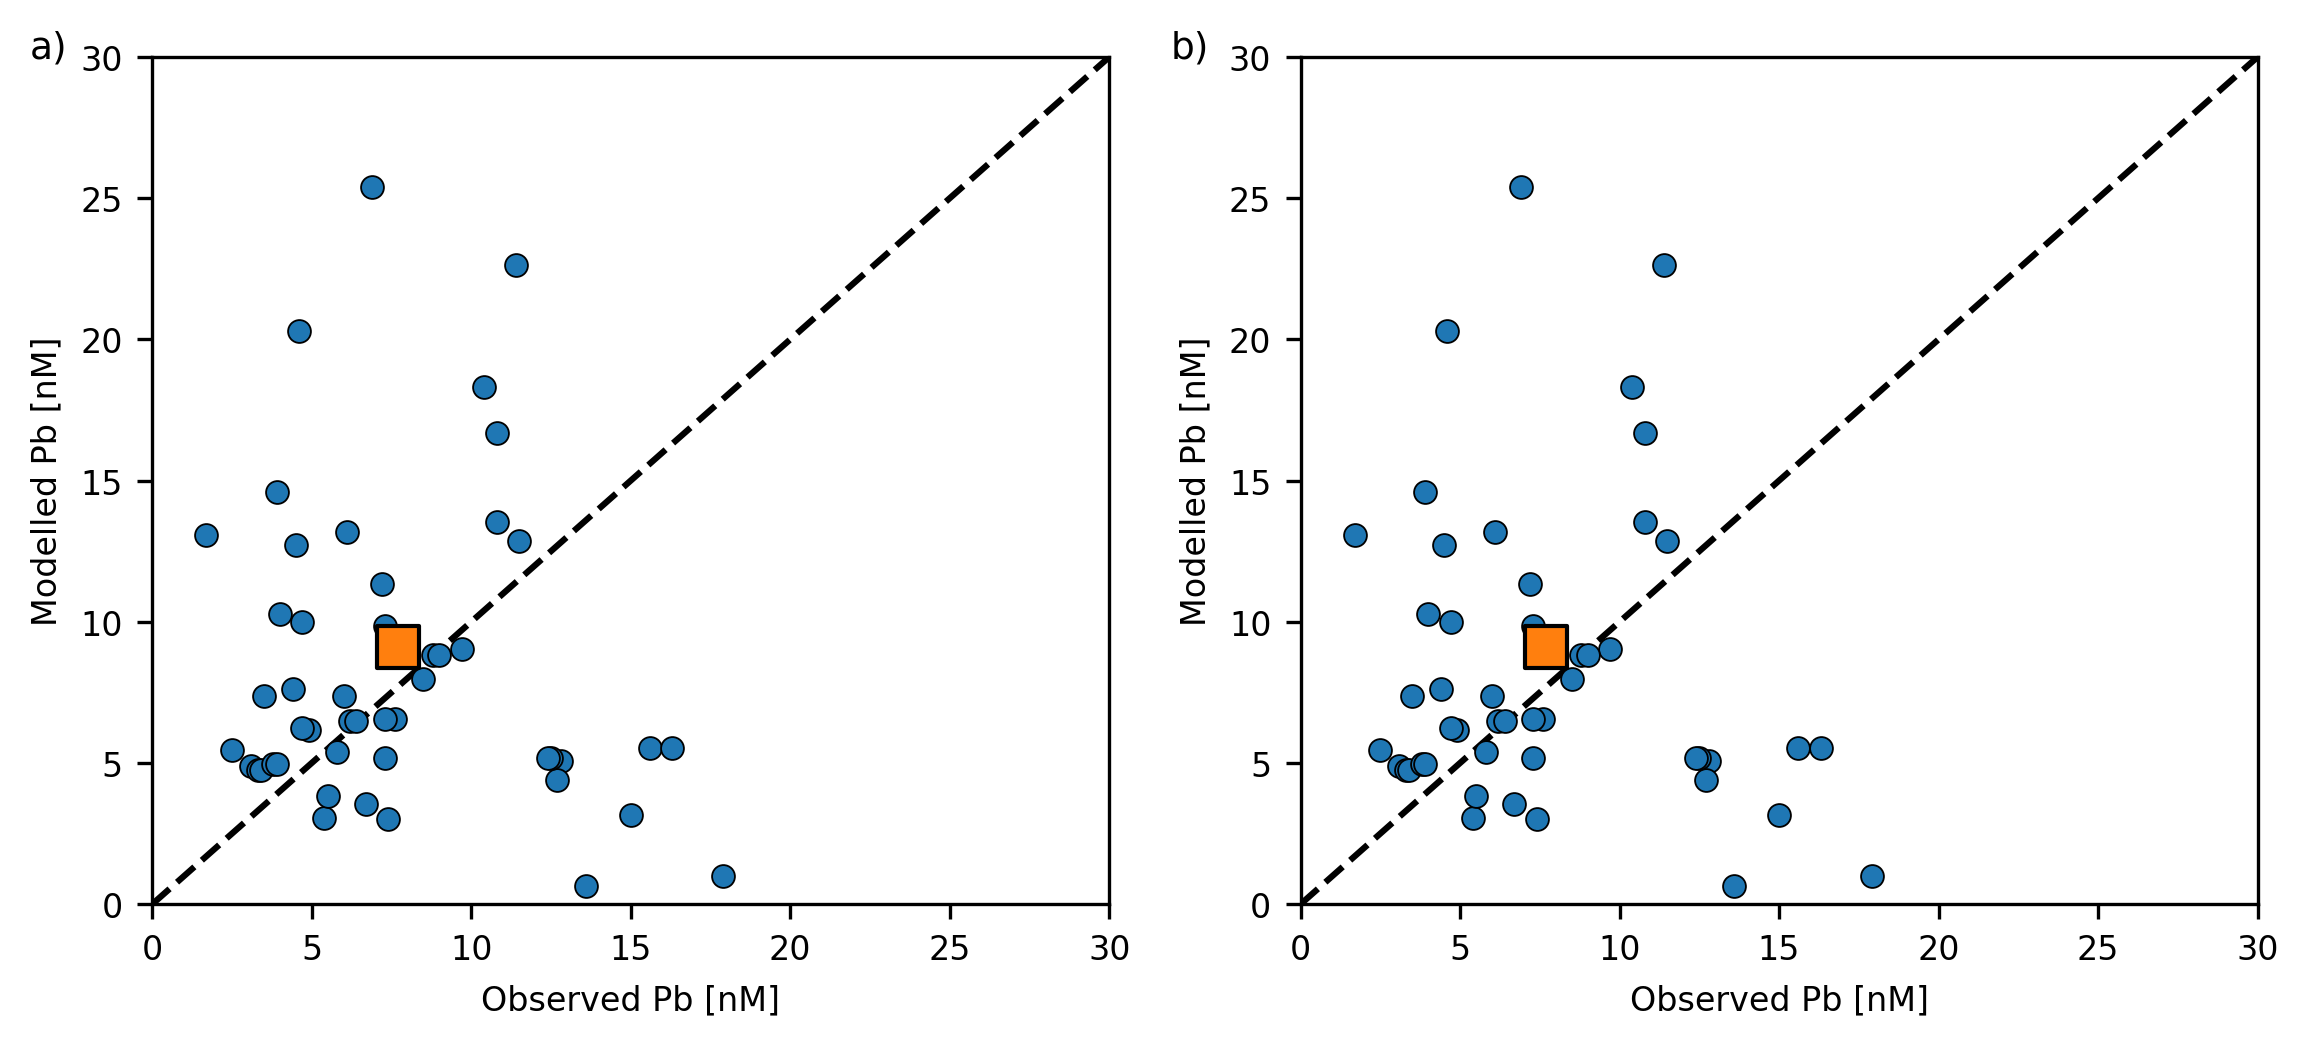

In [44]:
fig, ax = plt.subplots(1,2, figsize=(9.055, 3.74), dpi=300)
st = sns.axes_style("ticks")

with st:   
    for axis in ax:
        line1 = sns.lineplot([0, 40],[0, 40], c='k', linewidth=1.5, zorder=1, ax=axis)
        line1.lines[0].set_linestyle('--')
        axis.set_xlabel('Observed Pb [nM]', fontsize=8)
        axis.set_ylabel('Modelled Pb [nM]',fontsize=8)
        axis.set(xlim=(0, 30.), ylim=(0, 30.))
        axis.tick_params(axis='both', which='major', labelsize=8) 

    ### Left plot ###
    sns.scatterplot(dpb_obs_all.flatten(), dpb_ref_all.flatten(), s=30, \
                    edgecolor='k', zorder=2, ax=ax[0])
    sns.scatterplot([np.nanmean(dpb_obs_all)], [np.nanmean(dpb_ref_all)], s=100, linewidth=1.0, \
                    edgecolor='k', marker='s', zorder=3, ax=ax[0])
#     ax[0].legend(loc=(0.01, 0.86), frameon=False, fontsize=8)
    
    ### Right plot ###
    sns.scatterplot(dpb_obs_all.flatten(), dpb_ref_all.flatten(), s=30, \
                    edgecolor='k', zorder=2, ax=ax[1])
    sns.scatterplot([np.nanmean(dpb_obs_all)], [np.nanmean(dpb_ref_all)], s=100, linewidth=1.0, \
                     edgecolor='k', marker='s', zorder=3, ax=ax[1])
#     ax[1].legend(loc=(0.01, 0.86), frameon=False, fontsize=8)
    
#-----------------------------------------------------------------------------------------------------------------------------------
### Full figure ###
fig.text(0.08, 0.88, 'a)', fontsize=9);
fig.text(0.50, 0.88, 'b)', fontsize=9);

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202204/R3-model-vs-observations.jpg', \
#                bbox_inches='tight', dpi=300, transparent=True)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202204/R3-model-vs-observations.svg', \
#                bbox_inches='tight', dpi=300, format='svg')